In [14]:
import pandas as pd
import re
import json
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [15]:
reviews_df = pd.read_csv('reviews.csv')
reviews_df.drop(columns=['hotel', 'reviewed_date', 'visit_date', 'rating', 'title'], inplace=True)

reviews_df['text_length'] = reviews_df['text'].str.len()

contains_question_mark = []
contains_exclamation_mark = []
contains_multiple_question_marks = []
contains_multiple_exclamation_marks = []
contains_multiple_dots = []
contains_happy_emotes = []
num_of_happy_emotes = []
contains_sad_emotes = []
num_of_sad_emotes = []
fraction_uppercase = []

for index, row in reviews_df.iterrows():
    if '?' in row['text']:
        contains_question_mark.append(1)
    else:
        contains_question_mark.append(0)
    if '!' in row['text']:
        contains_exclamation_mark.append(1)
    else:
        contains_exclamation_mark.append(0)
    if re.search("[?][?+]", row['text']):
        contains_multiple_question_marks.append(1)
    else:
        contains_multiple_question_marks.append(0)
    if re.search("[!][!+]", row['text']):
        contains_multiple_exclamation_marks.append(1)
    else:
        contains_multiple_exclamation_marks.append(0)
    if re.search("[.][.+]", row['text']):
        contains_multiple_dots.append(1)
    else:
        contains_multiple_dots.append(0)
    if re.search(r'([:;](-?)[pP])|([:;](-?)\))|([:;x](-?)[dD])', row['text']):
        contains_happy_emotes.append(1)
        num_of_happy_emotes.append(len(re.findall(r'([:;](-?)[pP])|([:;](-?)\))|([:;x](-?)[dD])', row['text'])))
    else:
        contains_happy_emotes.append(0)
        num_of_happy_emotes.append(0)
    if re.search(r'([:;](-?)\()', row['text']):
        contains_sad_emotes.append(1)
        num_of_sad_emotes.append(len(re.findall(r'([:;](-?)\()', row['text'])))
    else:
        contains_sad_emotes.append(0)
        num_of_sad_emotes.append(0)
    text_length = len(row['text'])
    num_of_upper = 0
    for char in row['text']:
        if char.isupper():
            num_of_upper += 1
    fraction_uppercase.append((num_of_upper / text_length) * 100)

reviews_df['contains_question_mark'] = contains_question_mark
reviews_df['contains_exclamation_mark'] = contains_exclamation_mark
reviews_df['contains_multiple_question_marks'] = contains_multiple_question_marks
reviews_df['contains_multiple_exclamation_marks'] = contains_multiple_exclamation_marks
reviews_df['contains_multiple_dots'] = contains_multiple_dots
reviews_df['contains_happy_emotes'] = contains_happy_emotes
reviews_df['num_of_happy_emotes'] = num_of_happy_emotes
reviews_df['contains_sad_emotes'] = contains_sad_emotes
reviews_df['num_of_sad_emotes'] = num_of_sad_emotes
reviews_df['fraction_uppercase'] = fraction_uppercase
reviews_df.drop(columns=['text'], inplace=True)

In [16]:
sentiment_df = pd.read_csv('sentiment_preprocessed_reviews.csv')
sentiment_df.drop(columns=['hotel', 'reviewed_date', 'visit_date', 'rating', 'title', 'text', 'preprocessed_text'],
                  inplace=True)
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda row: json.loads(str(row).replace("\'", "\"")))
sentiment_df['Positive_Score'] = sentiment_df['sentiment'].apply(
    lambda row: row['score'] if row['label'] == 'POSITIVE' else 0)
sentiment_df['Negative_Score'] = sentiment_df['sentiment'].apply(
    lambda row: row['score'] if row['label'] == 'NEGATIVE' else 0)
sentiment_df.drop(columns=['sentiment'], inplace=True)

grouped_reviews_df = reviews_df.groupby(['user']).mean()
grouped_sentiment_df = sentiment_df.groupby(['user']).mean()
combined_df = grouped_reviews_df.join(grouped_sentiment_df)

In [17]:
users_df = pd.read_csv('preprocessed_users.csv')
users_df = users_df[
    ['user', 'age', 'location', 'distribution_excellent', 'distribution_very_good', 'distribution_avergae',
     'distribution_poor', 'distribution_terrible', 'gender']]
users_df.drop(columns=['age', 'location'], inplace=True)

grouped_users_df = users_df.groupby(['user']).mean()
final_features_df = combined_df.join(grouped_users_df)

In [18]:
users_df = users_df.sort_values('user')
users_df.reset_index(inplace=True)
users_df.drop(
    columns=['index', 'distribution_excellent', 'distribution_very_good', 'distribution_avergae', 'distribution_poor',
             'distribution_terrible'], inplace=True)

final_df = pd.merge(final_features_df, users_df, on='user', how='left')
df = final_df.dropna(subset=['distribution_excellent'])

In [19]:
train_data = df.loc[~df.gender.isna()]
test_data = df.loc[df.gender.isna()]
# train_data.to_csv("train_data.csv", index=False, encoding='utf-8-sig', quoting=csv.QUOTE_ALL)

x = train_data.iloc[:, 1:-1].values
y = train_data.iloc[:, -1].values
x_test = test_data.iloc[:, 1:-1].values

le = LabelEncoder()
y = le.fit_transform(y)

sc = StandardScaler()
x[:, :] = sc.fit_transform(x[:, :])
x_test[:, :] = sc.transform(x_test[:, :])

model = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=6, class_weight='balanced',
                               random_state=0, n_jobs=-1)

scoring = ['accuracy', 'balanced_accuracy']
scores = cross_validate(model, x, y, scoring=scoring, cv=10, n_jobs=-1, return_train_score=False)
for s in scoring:
    print(f'{s}: {round(scores["test_" + s].mean(),2)} (+/- {round(scores["test_" + s].std(),2)})')

model.fit(x, y)
y_pred = model.predict(x_test)
y_out = le.inverse_transform(y_pred)

test_data['gender'] = y_out

filled_df = pd.concat([train_data, test_data])
filled_df.to_csv("filled_data.csv", index=False, encoding='utf-8-sig', quoting=csv.QUOTE_ALL)

accuracy: 0.62 (+/- 0.01)
balanced_accuracy: 0.6 (+/- 0.01)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
reviews = pd.read_csv('preprocessed_reviews.csv', encoding='utf8')
reviews.drop(columns=['hotel', 'reviewed_date', 'visit_date', 'rating', 'title'], inplace=True)

reviews_gender_df = pd.merge(reviews, filled_df)
reviews_gender_df.drop(columns=['user', 'text', 'text_length', 'contains_question_mark', 'contains_exclamation_mark',
                                'contains_multiple_question_marks', 'contains_multiple_exclamation_marks',
                                'contains_multiple_dots', 'contains_happy_emotes', 'num_of_happy_emotes',
                                'contains_sad_emotes', 'num_of_sad_emotes', 'fraction_uppercase', 'Positive_Score',
                                'Negative_Score', 'distribution_excellent', 'distribution_very_good',
                                'distribution_avergae', 'distribution_poor', 'distribution_terrible'], inplace=True)

In [21]:
from wordcloud import WordCloud, STOPWORDS

woman_reviews_text = []
man_reviews_text = []
for index, row in reviews_gender_df.iterrows():
    if row['gender'] == 'woman':
        woman_reviews_text.extend(str(row['preprocessed_text']).split(','))
    elif row['gender'] == 'man':
        man_reviews_text.extend(str(row['preprocessed_text']).split(','))
woman_reviews_text = ' '.join(woman_reviews_text)
man_reviews_text = ' '.join(man_reviews_text)
stop_words = ['hotel', 'room', 'breakfast'] + list(STOPWORDS)

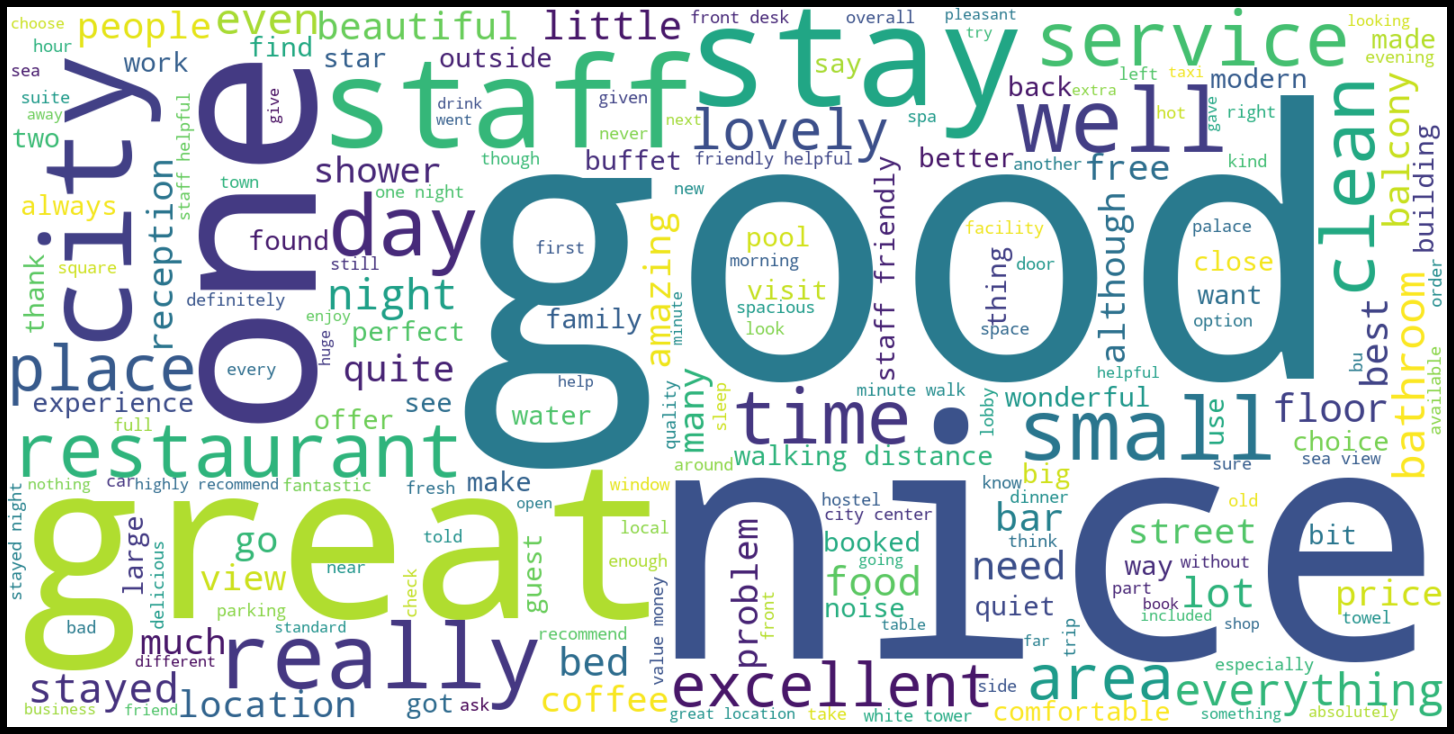

In [22]:
import matplotlib.pyplot as plt

woman_wordcloud = WordCloud(width=1600, height=800, stopwords=stop_words, background_color="white").generate(
    woman_reviews_text)
plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(woman_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

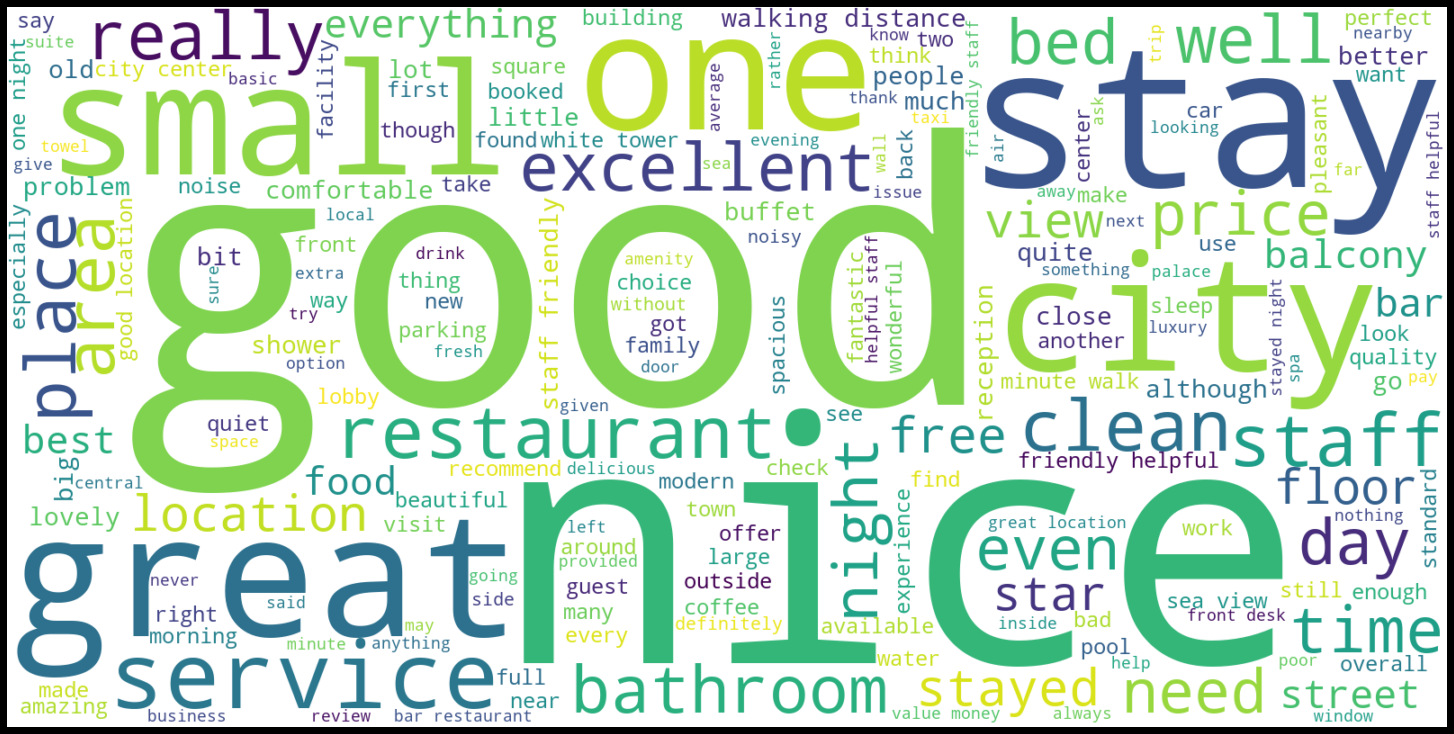

In [23]:
man_wordcloud = WordCloud(width=1600, height=800, stopwords=stop_words, background_color="white").generate(
    man_reviews_text)
plt.figure(figsize=(20, 10), facecolor='k')
plt.imshow(man_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()